# Exploring PyMC for Bayesian Modeling (Part 1)

## Sample Data

In [1]:
import numpy as np
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# True parameter values
alpha = 1 # for intercept term
beta = [1, 2.5] # for the coefficients of two independent variables X1 and X2
sigma = 1 # sd of the residuals

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.7

# Simulate outcome variable Y
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

### Plot Data

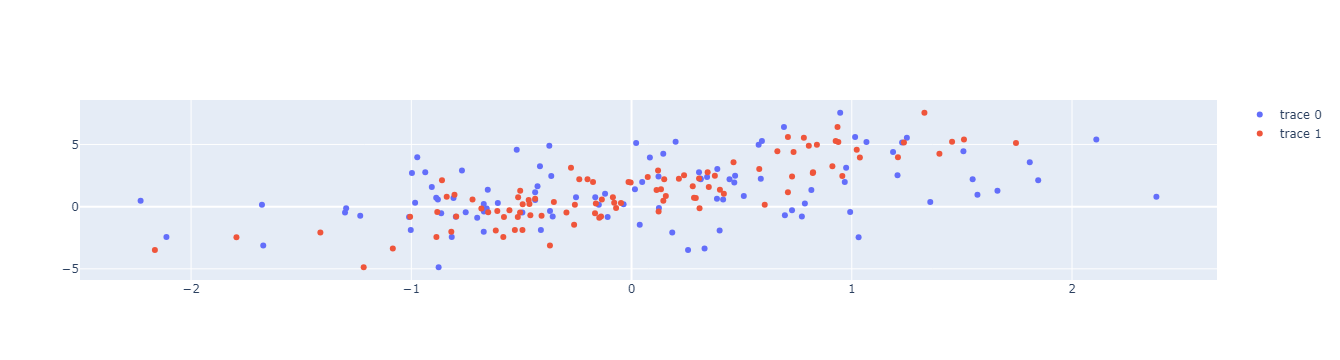

In [2]:
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *

init_notebook_mode(connected=True)         # initiate notebook for offline plot

trace0 = Scatter(
  x=X1,
  y=Y,
  mode='markers'  
)
trace1 = Scatter(
  x=X2,
  y=Y,
  mode='markers'  
)

iplot([trace0, trace1]) 

## Create PyMC Model

In [3]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.16.2


### Define Model

In [4]:
basic_model = pm.Model()
with basic_model:
    alpha = pm.Normal('alpha', mu=1, sigma=10)
    beta = pm.Normal('beta', mu=2.5, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = alpha + beta[0]*X1 + beta[1]*X2
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

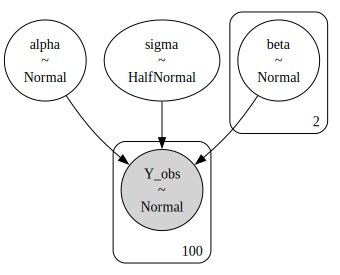

In [5]:
pm.model_to_graphviz(basic_model)

### Run Sampling

In [6]:
with basic_model:
    idata = pm.sample(draws=4000, 
                     tune = 1000, 
                     chains = 4,
                     cores = 2,
                     nuts_sampler = "pymc",
                     discard_tuned_samples = True,
                     compute_convergence_checks = True,
                     return_inferencedata = True,
                     idata_kwargs = {"log_likelihood": True}, 
                     nuts_sampler_kwargs = {"target_accept":0.95}
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 53 seconds.


## Inference Data

In [7]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Alpha

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

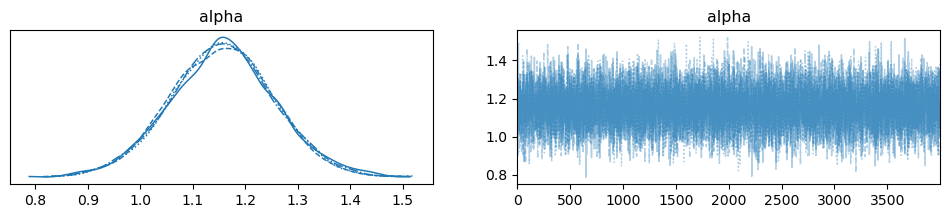

In [8]:
import arviz as az
az.plot_trace(idata, var_names="alpha")

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

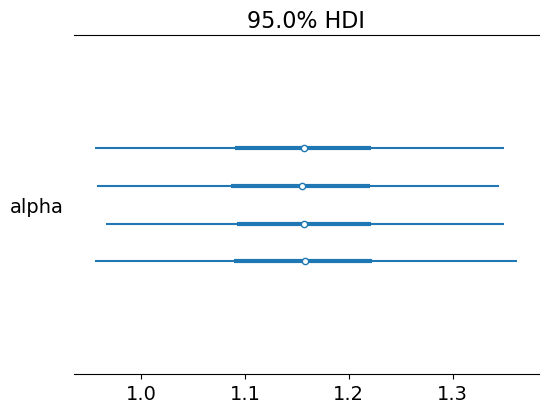

In [9]:
az.plot_forest(idata, var_names="alpha", hdi_prob=0.95)

array([<Axes: title={'center': 'alpha\n0'}>,
       <Axes: title={'center': 'alpha\n1'}>,
       <Axes: title={'center': 'alpha\n2'}>,
       <Axes: title={'center': 'alpha\n3'}>], dtype=object)

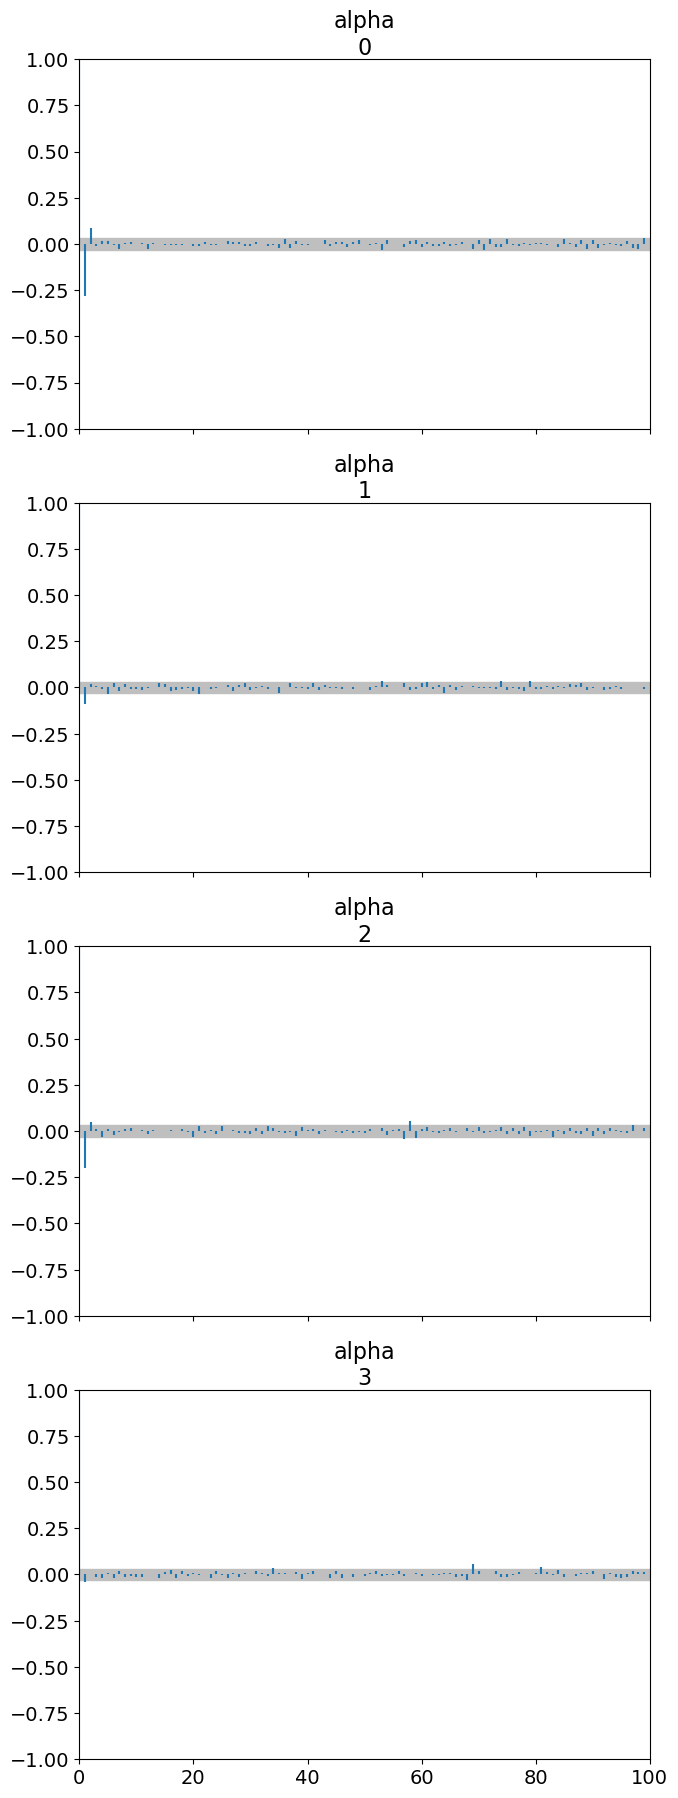

In [10]:
az.plot_autocorr(idata, var_names="alpha", grid=(4,1))

### Beta

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

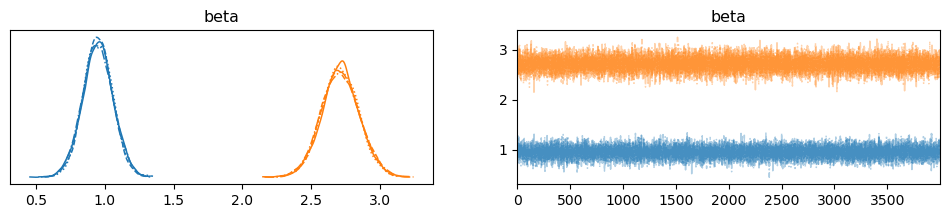

In [11]:
az.plot_trace(idata, var_names="beta")

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

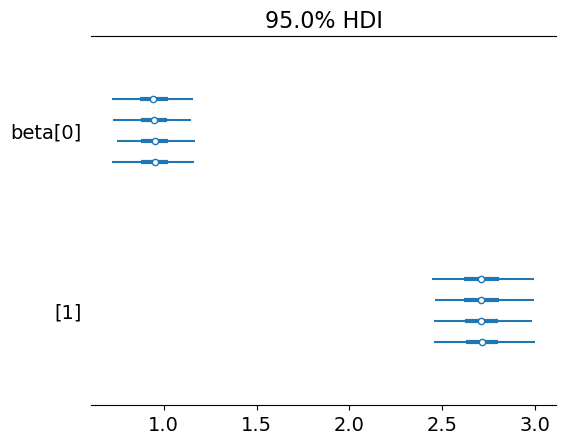

In [12]:
az.plot_forest(idata, var_names="beta", hdi_prob=0.95)

array([[<Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>],
       [<Axes: title={'center': 'beta\n1, 0'}>,
        <Axes: title={'center': 'beta\n1, 1'}>],
       [<Axes: title={'center': 'beta\n2, 0'}>,
        <Axes: title={'center': 'beta\n2, 1'}>],
       [<Axes: title={'center': 'beta\n3, 0'}>,
        <Axes: title={'center': 'beta\n3, 1'}>]], dtype=object)

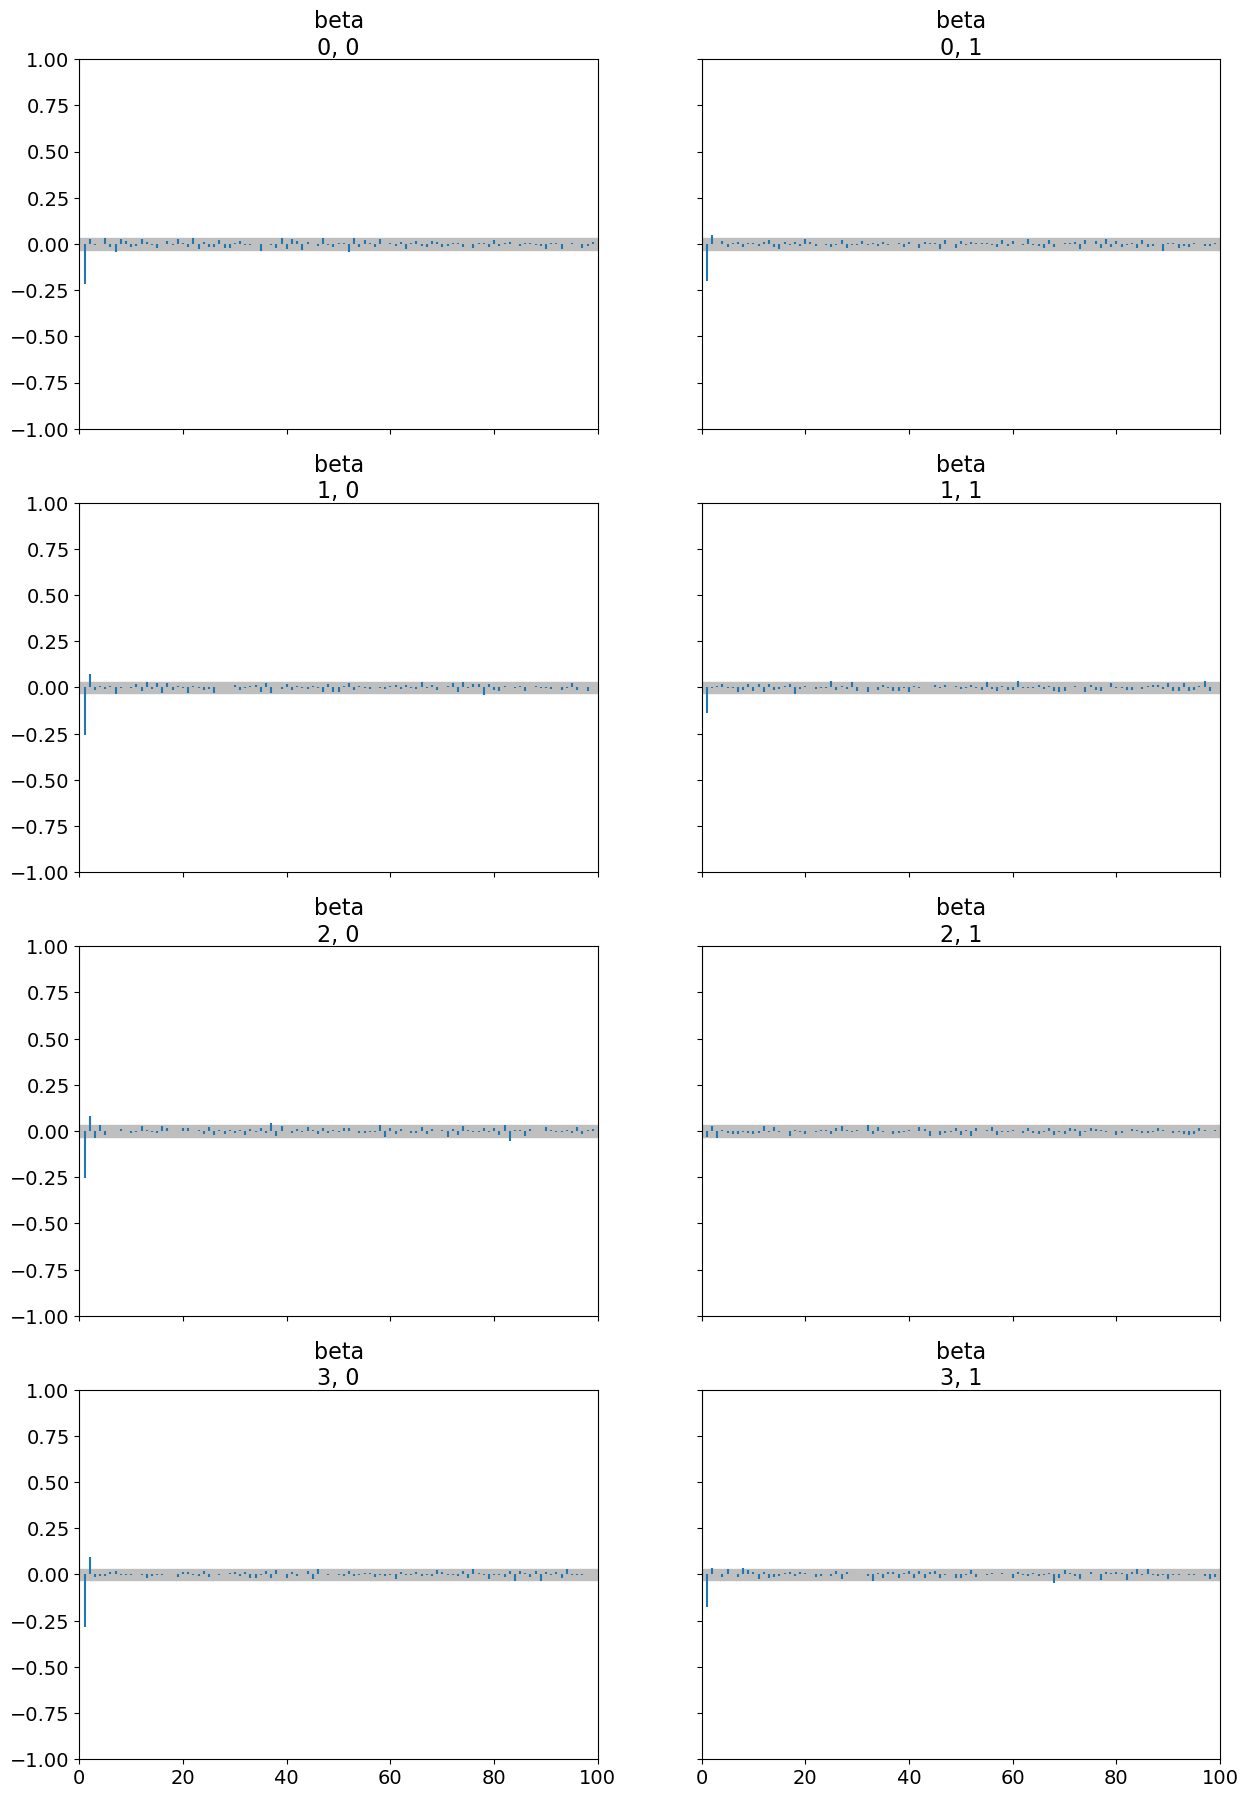

In [13]:
az.plot_autocorr(idata, var_names="beta", grid=(4,2))

### Sigma

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

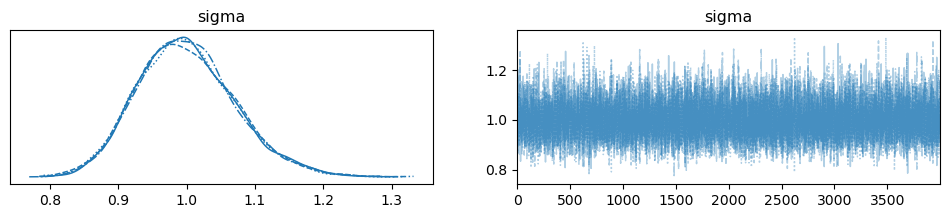

In [14]:
az.plot_trace(idata, var_names="sigma")

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

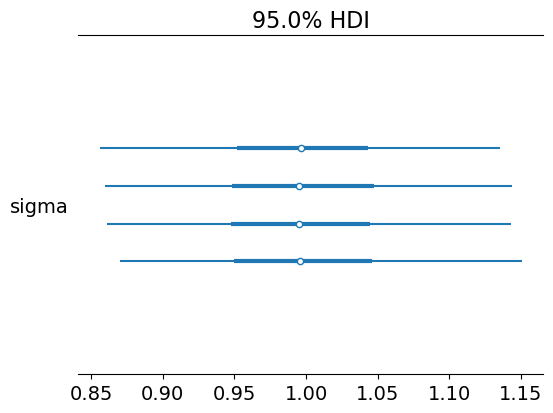

In [15]:
az.plot_forest(idata, var_names="sigma", hdi_prob=0.95)

array([<Axes: title={'center': 'sigma\n0'}>,
       <Axes: title={'center': 'sigma\n1'}>,
       <Axes: title={'center': 'sigma\n2'}>,
       <Axes: title={'center': 'sigma\n3'}>], dtype=object)

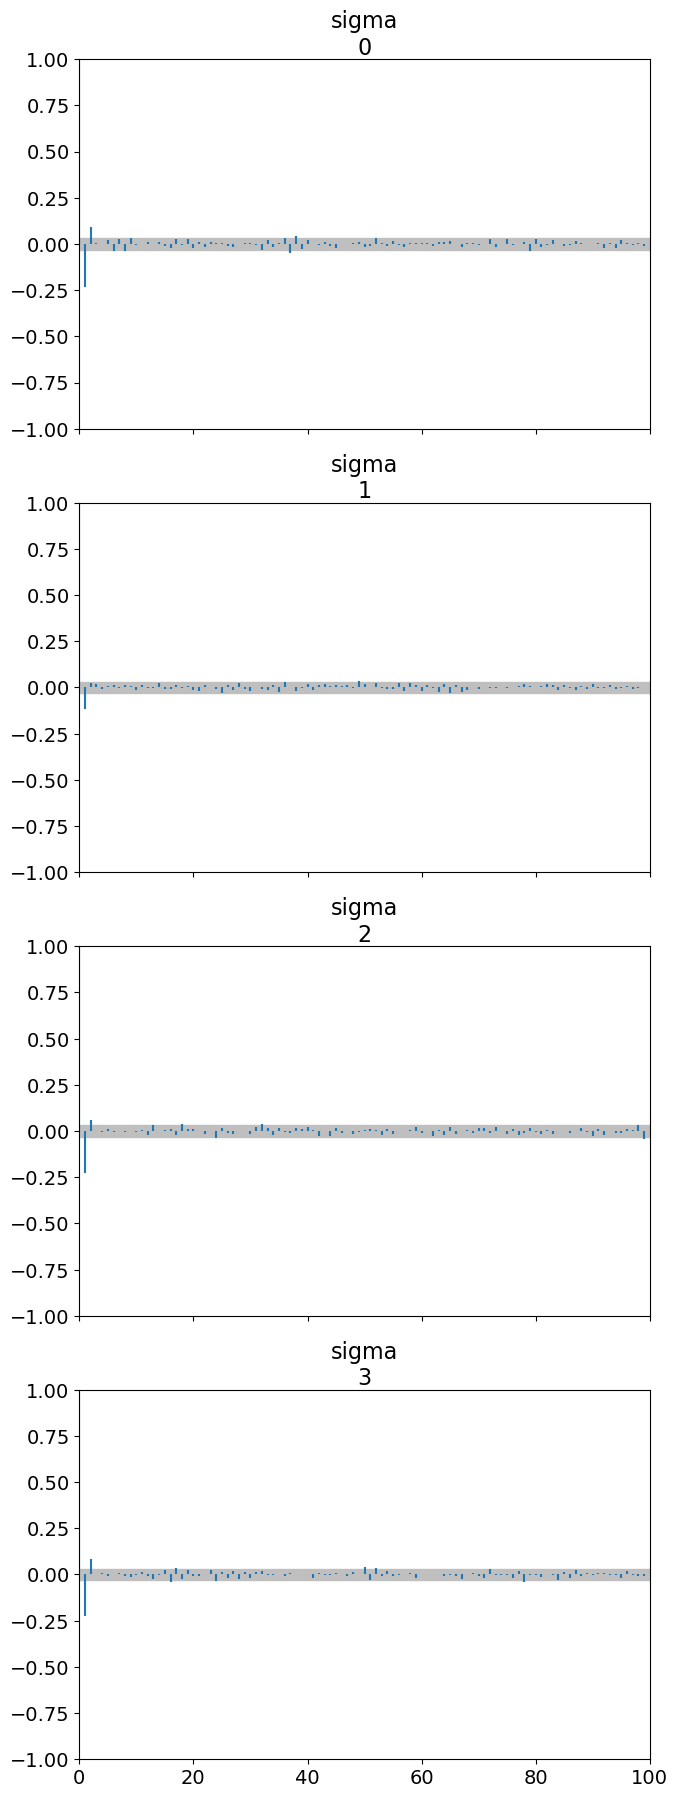

In [16]:
az.plot_autocorr(idata, var_names="sigma", grid=(4,1))

### Summary

In [17]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.156,0.100,0.956,1.350,0.001,0.000,20945.0,13466.0,1.0
beta[0],0.949,0.109,0.732,1.162,0.001,0.000,26425.0,13580.0,1.0
beta[1],2.713,0.137,2.454,2.994,0.001,0.001,20820.0,12610.0,1.0
sigma,1.000,0.072,0.863,1.146,0.000,0.000,22120.0,12676.0,1.0


## Goodness of Fit

In [18]:
with basic_model:
    idata_posterior_pc = pm.sample_posterior_predictive(trace=idata)

Sampling: [Y_obs]


Output()

<Axes: xlabel='Y_obs'>

C:\Users\tumpa\Documents\Tanmay Sarkar\workspace\probabilistic-programming\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\tumpa\Documents\Tanmay Sarkar\workspace\probabilistic-programming\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



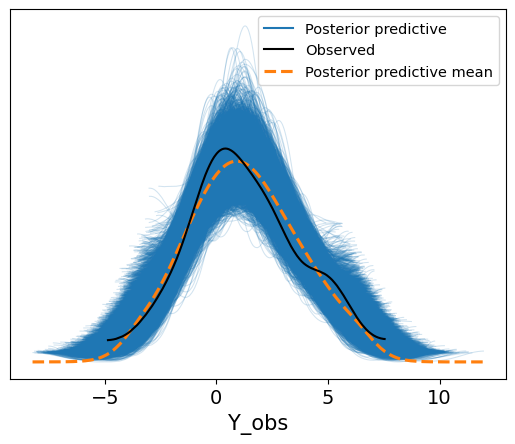

In [19]:
az.plot_ppc(idata_posterior_pc)

In [20]:
y_true = idata.observed_data["Y_obs"].values
y_pred = idata_posterior_pc.posterior_predictive.stack(sample=("chain", "draw"))["Y_obs"].values.T
az.r2_score(y_true, y_pred)

r2        0.752700
r2_std    0.030343
dtype: float64

In [21]:
az.loo(idata)

Computed from 16000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -143.57     6.45
p_loo        3.84        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      100  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%